In [1]:
# Основные фреймворки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Отключение ворнингов
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Настройка визуализации
import matplotlib
TEXT_COLOR = 'black'

matplotlib.rcParams['text.color'] = TEXT_COLOR
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['lines.markersize'] = 15
matplotlib.rcParams['axes.labelcolor'] = TEXT_COLOR
matplotlib.rcParams['xtick.color'] = TEXT_COLOR
matplotlib.rcParams['ytick.color'] = TEXT_COLOR

sns.set_style("whitegrid")

In [46]:
# Импорт используемых фреймворков
from phik import phik_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, classification_report, f1_score, plot_precision_recall_curve, plot_roc_curve

------------
### Первичный анализ данных

In [4]:
# Загрузка данных
df = pd.read_csv('drug200.csv')
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [5]:
# Размер данных
df.shape

(200, 6)

#### Описание признаков
- age - возраст
- sex - пол
- BP - давление
- Cholesterol - Уровни холестерина
- Na_to_K - Соотношение Na к калию

In [6]:
# Типы данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [7]:
# Уникальные значения 
df.nunique()

Age             57
Sex              2
BP               3
Cholesterol      2
Na_to_K        198
Drug             5
dtype: int64

- Признаки Sex, BP, Cholesterol, Drug имеют дискретные значения 
- Age,  Na_to_K представляют непрерывный тип данных

In [8]:
# непрерывные и дискретные признаки
continuous_сol = ['Age', 'Na_to_K']
discrete_col = ['Sex', 'BP', 'Cholesterol']
target_col = ['Drug']

In [9]:
# Пропуски значений
df.isna().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

В данных отсутствуют пропуски.

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,200.0,44.315000,16.544315,15.000,31.0000,45.0000,58.00,74.000
Na_to_K,200.0,16.084485,7.223956,6.269,10.4455,13.9365,19.38,38.247


#### Анализ целевого признака


In [11]:
def viz_discr(feature):
    # Функция визуализации дискретных признаков
    print(f'Процентное соотношение классов в признаке {feature}')
    print(100 * df[feature].value_counts() / len(df))
    
    plt.figure(figsize=(8,5))
    sns.countplot(df[feature], palette="GnBu_d")
    plt.title(f'Count plot {feature}')
    plt.tight_layout()

Процентное соотношение классов в признаке Drug
DrugY    45.5
drugX    27.0
drugA    11.5
drugC     8.0
drugB     8.0
Name: Drug, dtype: float64


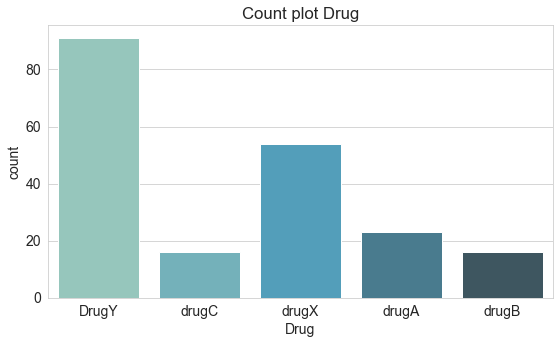

In [12]:
viz_discr('Drug')

В целевом признаке наблюдается дисбаланс классов. DrugY составляет 45.5% от всех данных, drugX составляет 27%, drugA - 11.5%, drugB и drugC составляют 8%.

#### Анализ дискретных признаков

Процентное соотношение классов в признаке Sex
M    52.0
F    48.0
Name: Sex, dtype: float64


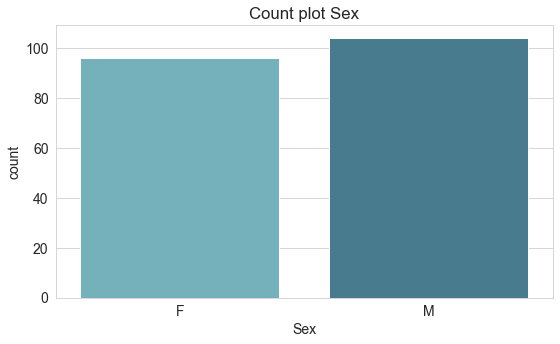

In [13]:
# SEX
viz_discr('Sex')

- Дисбаланс в признаке отсутствует.
- В предобработке признак можно привести к бинарному виду [0, 1]. 

Процентное соотношение классов в признаке BP
HIGH      38.5
LOW       32.0
NORMAL    29.5
Name: BP, dtype: float64


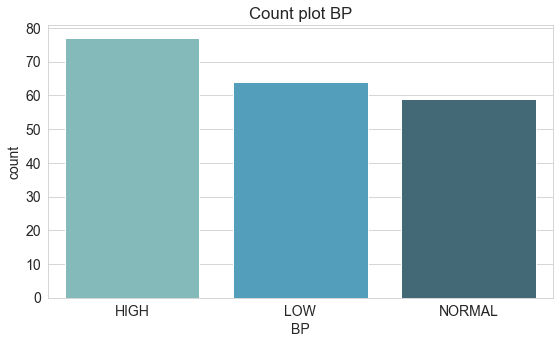

In [14]:
# BP
viz_discr('BP')

- Дисбаланса в распределении классов признака Давление не наблюдается. Но наибольшее количество наблюдений фиксировало высокий уровень кровяного давления.
- В предобработке признак можно привести к категориальному числовому виду.

Процентное соотношение классов в признаке Cholesterol
HIGH      51.5
NORMAL    48.5
Name: Cholesterol, dtype: float64


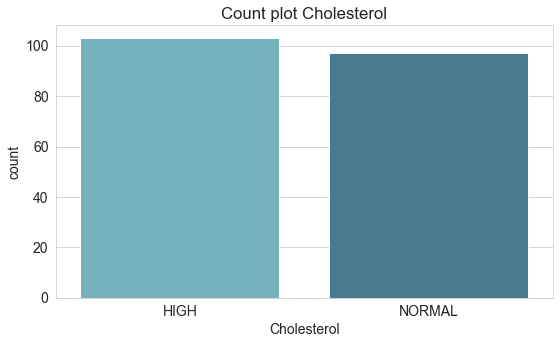

In [15]:
# Холестерин
viz_discr('Cholesterol')

- Дисбаланса в распределении классов признака Холестерин не наблюдается. Но наибольшее количество наблюдений фиксировало высокий уровень кровяного давления.
- В предобработке признак можно привести к категориальному бинарному виду [0, 1].

#### Анализ взаимодействия дискретных признаков c целевым признаком

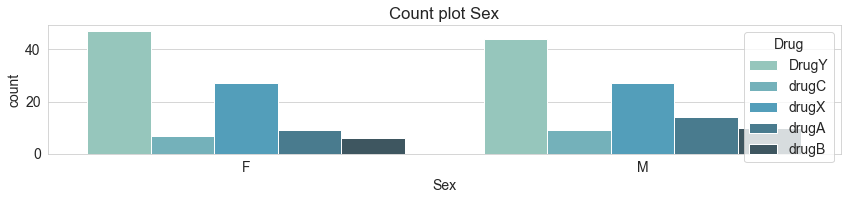

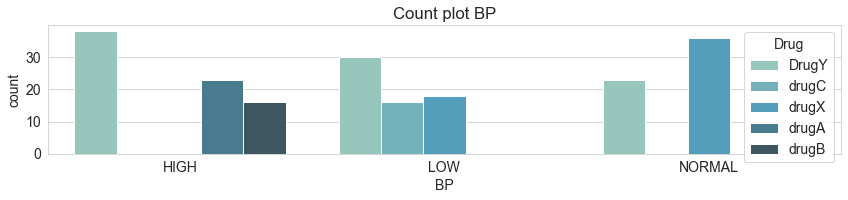

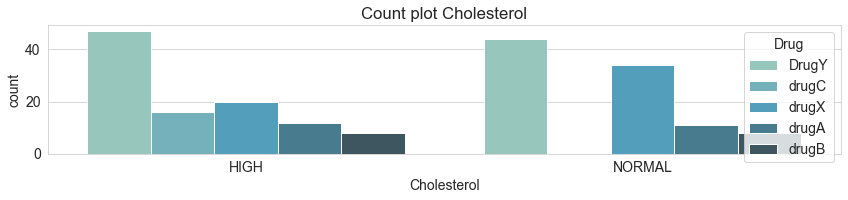

In [16]:
for feature in discrete_col:
    plt.figure(figsize=(12,3))
    sns.countplot(data=df, x=feature, hue='Drug', palette="GnBu_d")
    plt.title(f'Count plot {feature}')
    plt.tight_layout()

- Распределение Пола в зависимости от класса Наркотика почти не зависит.
- По распределению Кровяного давления видно, что drugC в основном фиксируется при низком BP, а drugB и drugА при высоком BP. Нормальное давление чаще всего фиксировалось при drugX.
- По распределению Холестерина видно, что drugC в основном наблюдается при высоком уровне Холестерина, а drugX чаще фиксировался при нормальном уровне Холестерина. Остальные классы целевого признака не так зависимы от уровня Холестерина.  


#### Анализ непрерывных признаков

In [17]:
def viz_cont(feature):
    print(F'Минимальный {feature}: {min(df[feature])}')
    print(F'Максимальный {feature}: {max(df[feature])}')
    plt.figure(figsize=(15,4))
    sns.distplot(df[feature], bins=50, color='gray')
    plt.title(f'Распределение признака {feature}')
    plt.tight_layout()

    plt.figure(figsize=(15,4))
    sns.kdeplot(data=df, x=feature, hue='Drug', palette="GnBu_d")
    plt.title(f'Распределение признака {feature} c учетом целевого признака')
    plt.tight_layout()


Минимальный Age: 15
Максимальный Age: 74


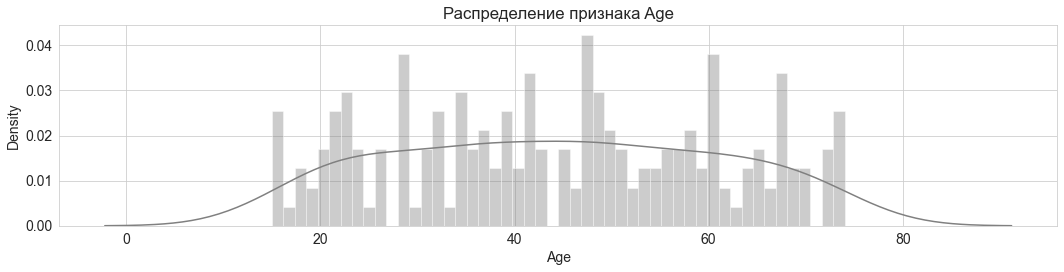

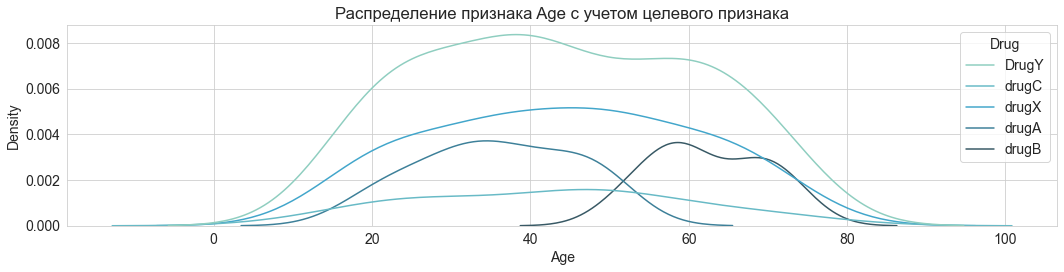

In [18]:
# Age
viz_cont('Age')

- Границы измерений [15, 74].
- Форма KDE напоминает плато
- Классы целевого признака drugY, dragX, drugC имеют распределение схожее с общим распределением признака Age
- Классы drugA и drugB имеют границы наблюдений уже

In [19]:
# Границы измерений drugY
print('max Age drugY', max(df.loc[df.Drug=='DrugY']['Age']))
print('min Age drugY', min(df.loc[df.Drug=='DrugY']['Age']))
print('-----------------')

# Границы измерений drugA 
print('max Age drugA', max(df.loc[df.Drug=='drugA']['Age']))
print('min Age drugA', min(df.loc[df.Drug=='drugA']['Age']))
print('-----------------')

# Границы измерений drugB
print('max Age drugB', max(df.loc[df.Drug=='drugB']['Age']))
print('min Age drugB', min(df.loc[df.Drug=='drugB']['Age']))

max Age drugY 74
min Age drugY 15
-----------------
max Age drugA 50
min Age drugA 19
-----------------
max Age drugB 74
min Age drugB 51


Минимальный Na_to_K: 6.269
Максимальный Na_to_K: 38.247


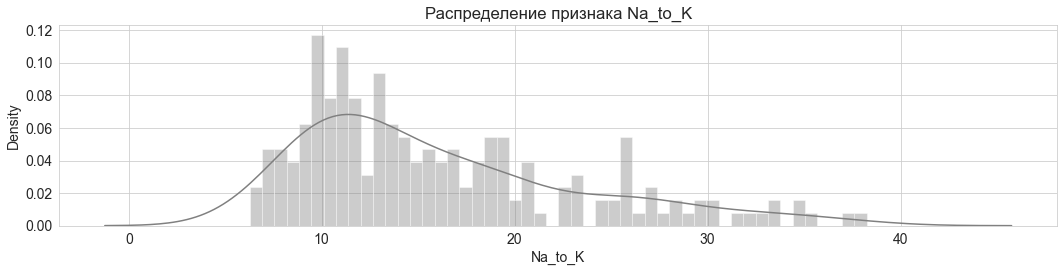

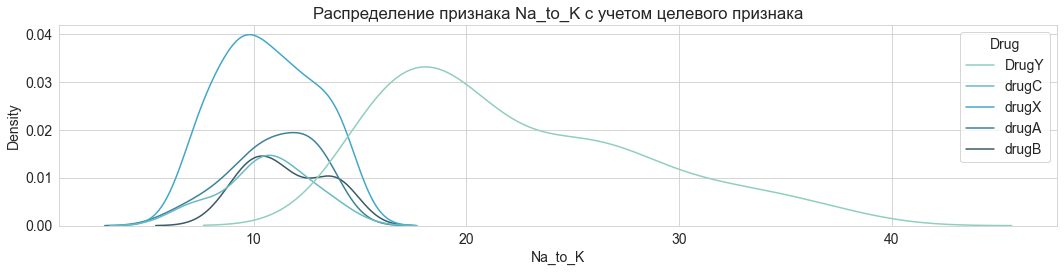

In [20]:
# Na_to_K
viz_cont('Na_to_K')

- Границы измерений [6.269, 38.247].
- Форма KDE напоминает нормальное распределение с асимметрией "правый хвост"
- Распределение класса  drugY отличается от всех остальных классов и является прчииной ассиметрии.

In [21]:
# Границы измерений drugX
print('max Na_to_K drugX', max(df.loc[df.Drug=='drugX']['Na_to_K']))
print('min Na_to_K drugX', min(df.loc[df.Drug=='drugX']['Na_to_K']))
print('-----------------')

# Границы измерений drugY
print('max Na_to_K drugY', max(df.loc[df.Drug=='DrugY']['Na_to_K']))
print('min Na_to_K drugY', min(df.loc[df.Drug=='DrugY']['Na_to_K']))


max Na_to_K drugX 14.642
min Na_to_K drugX 6.683
-----------------
max Na_to_K drugY 38.247
min Na_to_K drugY 15.015


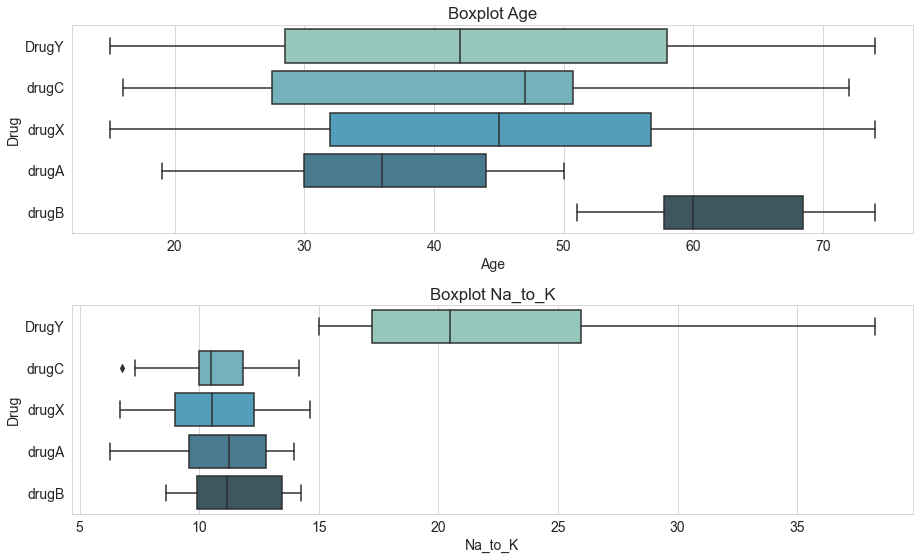

In [22]:
# График ящика с усами
plt.figure(figsize=(13,8))
plt.subplot(2, 1, 1)
sns.boxplot(data=df, x='Age', y='Drug', palette="GnBu_d")
plt.title('Boxplot Age')
plt.subplot(2, 1, 2)
sns.boxplot(data=df, x='Na_to_K', y='Drug', palette="GnBu_d")
plt.title('Boxplot Na_to_K')
plt.tight_layout()

- Выбросы в данных не наблюдается 
- Медианное значение Age drugA отличается от drugY, drugC, drugX.
- Значения признака Age drugB значительно отличаются от наблюдений других классов
- Значения Na_to_K drugY значительно отличаются от наблюдений других классов, что можно преобразовать в новый признак (Na_to_K > 15)

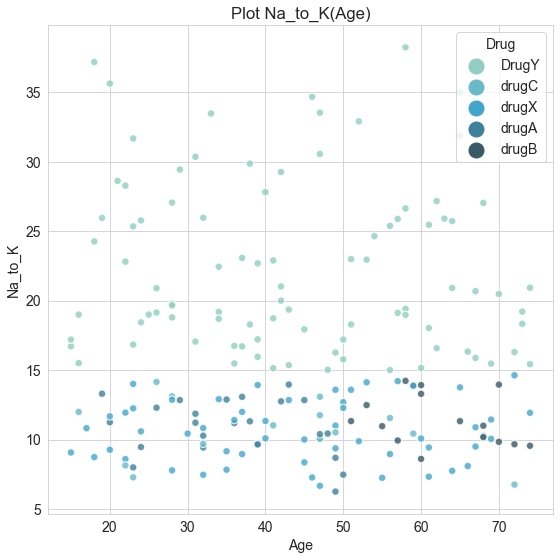

In [23]:
# Взаимосвязь Age и Na_to_K
plt.figure(figsize=(8,8))
sns.scatterplot(data=df, x='Age', y='Na_to_K', hue='Drug', palette="GnBu_d", alpha=0.8, marker='.')
plt.title('Plot Na_to_K(Age)')
plt.tight_layout()

На графике зависимости Na_to_K(Age) видно, что класс DrugY отделяется от остальных классов.

#### Анализ всех признаков

interval columns not set, guessing: ['Age', 'Na_to_K']


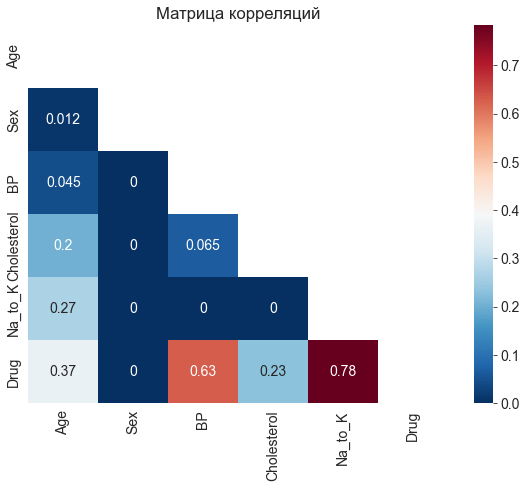

In [24]:
# Матрица корреляций
corr_mtrx = phik_matrix(df)

plt.figure(figsize=(8,7))
mask = np.zeros_like(corr_mtrx)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_mtrx, xticklabels=corr_mtrx.columns, yticklabels=corr_mtrx.columns, cmap='RdBu_r', annot=True, mask = mask)
plt.title('Матрица корреляций')
plt.tight_layout()

- Пол не коррелируют ни с одним признаком,
- Наибольшие коэффициенты корреляции наблюдаются между целевым признаком и признаками Na_to_K, BP

-------

### Предобработка

- Кодировка целевой перемнной в числовой вид
- Кодировка признаков типа object  в числовой категориальный вид: (Sex, BP, Cholesterol)
- Перевод Na_to_k в категориальный тип, где Na_to_K > 15 ---> 1, иначе 0

In [25]:
# Разделение выборок
features = df.drop('Drug', axis=1)
target = df['Drug']

features[discrete_col] = features[discrete_col].astype('category')

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.3, random_state=43, shuffle=True)
print(f'Размер обучающей выборки: {X_train.shape}, \n{y_train.value_counts()}\n')
print(f'Размер тестовой выборки: {X_test.shape}, \n{y_test.value_counts()}')

Размер обучающей выборки: (140, 5), 
DrugY    65
drugX    38
drugA    19
drugB    11
drugC     7
Name: Drug, dtype: int64

Размер тестовой выборки: (60, 5), 
DrugY    26
drugX    16
drugC     9
drugB     5
drugA     4
Name: Drug, dtype: int64


In [26]:
# Кодировка пола
encoder_sex = LabelEncoder()
encoder_sex.fit(X_train['Sex'].values.reshape(-1, 1))
X_train['Sex'] = encoder_sex.transform(X_train['Sex'].values.reshape(-1, 1))
X_test['Sex'] = encoder_sex.transform(X_test['Sex'].values.reshape(-1, 1))
print(f'Sex [0, 1] = {encoder_sex.classes_}')

# Кодировка BP
BP_values = ['LOW', 'NORMAL', 'HIGH']
encoder_BP = OrdinalEncoder(categories=[BP_values])
encoder_BP.fit(X_train['BP'].values.reshape(-1, 1))
X_train['BP'] = encoder_BP.transform(X_train['BP'].values.reshape(-1, 1))
X_test['BP'] = encoder_BP.transform(X_test['BP'].values.reshape(-1, 1))

# Кодировка BP
chl_values = ['NORMAL', 'HIGH']
encoder_chl = OrdinalEncoder(categories=[chl_values])
encoder_chl.fit(X_train['Cholesterol'].values.reshape(-1, 1))
X_train['Cholesterol'] = encoder_chl.transform(X_train['Cholesterol'].values.reshape(-1, 1))
X_test['Cholesterol'] = encoder_chl.transform(X_test['Cholesterol'].values.reshape(-1, 1))

Sex [0, 1] = ['F' 'M']


In [27]:
# Преобразование Na_to_K
def na_to_category(data):
    data['Na_to_K'].loc[data['Na_to_K'] < 15.0] = 0
    data['Na_to_K'].loc[data['Na_to_K'] >= 15.0] = 1
    data['Na_to_K'] = data['Na_to_K'].astype('category')
    return data

X_train = na_to_category(X_train)
X_test = na_to_category(X_test)

X_train.head()

,Age,Sex,BP,Cholesterol,Na_to_K
71,28,0,1.0,1.0,1.0
90,62,1,1.0,1.0,1.0
100,31,1,2.0,0.0,0.0
44,50,0,1.0,0.0,0.0
94,56,1,0.0,1.0,1.0


In [28]:
# Кодировка целевого признака
target_encoder = LabelEncoder()
target_encoder.fit(y_train.values.reshape(-1,1))
y_train = pd.Series(data=target_encoder.transform(y_train.values.reshape(-1,1)), index=y_train.index)
y_test = pd.Series(data=target_encoder.transform(y_test.values.reshape(-1,1)), index=y_test.index)
print(f'Drug [0, 1, 2, 3, 4] = {target_encoder.classes_}')

Drug [0, 1, 2, 3, 4] = ['DrugY' 'drugA' 'drugB' 'drugC' 'drugX']


-----------

### Моделирование

In [29]:
def modeling (model, params, X_train, y_train, X_test):
    # Функция настройки гиперпараметров модели и получения вектора предсказания
    
    grid = GridSearchCV(estimator=model, param_grid=params, scoring='f1_macro', cv=5)
    grid.fit(X_train, y_train)
    print(f'Лучшие параметры: {grid.best_params_}')
    
    model = grid.best_estimator_
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return model, y_pred

def metrics(true, pred):
    # Функция вывода метрик
    cm = confusion_matrix(true, pred)
    
    plt.figure(figsize=(7,5))
    ax = sns.heatmap(cm, annot=True, fmt='.0f', xticklabels=['DrugY', 'drugA', 'drugB', 'drugC', 'drugX'], yticklabels=['DrugY', 'drugA', 'drugB', 'drugC', 'drugX'], cmap='RdBu_r')
    ax.set_ylabel('TRUE')
    ax.set_xlabel('PREDICT')
    plt.show()
    
    report = classification_report(true, pred)
    return print(report)

In [30]:
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'K Neighbors', 'Gaussian NB', 'SVM']
scores = pd.Series(data = 0, index=models)

**Логистическая регрессия**

Лучшие параметры: {'C': 1.1629999999999998}


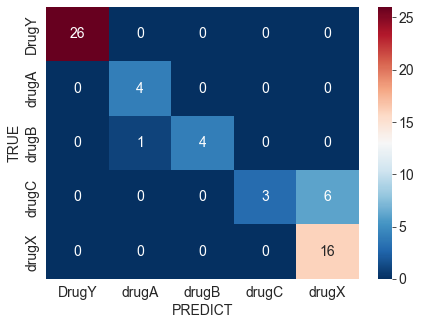

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       0.80      1.00      0.89         4
           2       1.00      0.80      0.89         5
           3       1.00      0.33      0.50         9
           4       0.73      1.00      0.84        16

    accuracy                           0.88        60
   macro avg       0.91      0.83      0.82        60
weighted avg       0.91      0.88      0.87        60

Wall time: 5min 37s


In [31]:
%%time
LR_model = LogisticRegression(random_state=42)
LR_params = {'C': np.arange(0.001, 1.5, 0.001)}

best_LR_model, LR_y = modeling (LR_model, LR_params, X_train, y_train, X_test)
metrics(y_test, LR_y)
scores['Logistic Regression'] = f1_score(y_test, LR_y, average='weighted')

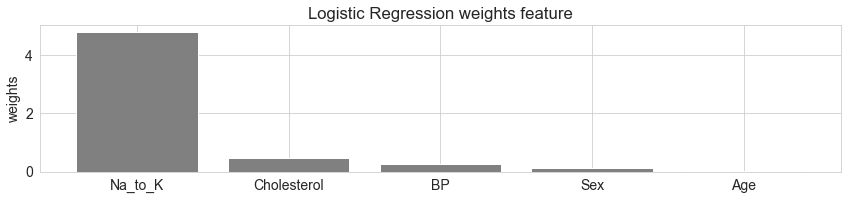

In [32]:
# Веса "вклада" признаков
weights_LR = pd.Series(data=abs(best_LR_model.coef_[0,:]), index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(12,3))
plt.bar(x=weights_LR.index, height=weights_LR.values, color='grey')
plt.ylabel('weights')
plt.title('Logistic Regression weights feature')
plt.tight_layout()

**Дерево решений**

Лучшие параметры: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1}


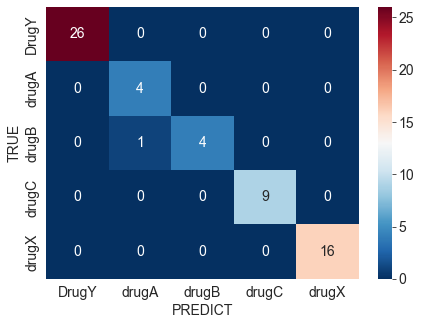

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       0.80      1.00      0.89         4
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00        16

    accuracy                           0.98        60
   macro avg       0.96      0.96      0.96        60
weighted avg       0.99      0.98      0.98        60

Wall time: 1.94 s


In [33]:
%%time
TREE_model = DecisionTreeClassifier(random_state=42)
TREE_params = {'criterion': ['gini', 'entropy', 'log_loss'],
            'max_depth': np.arange(2, 10, 2),
            'min_samples_leaf': np.arange(1, 5, 1)}

best_TREE_model, TREE_y = modeling (TREE_model, TREE_params, X_train, y_train, X_test)
metrics(y_test, TREE_y)
scores['Decision Tree'] = f1_score(y_test, TREE_y, average='weighted')

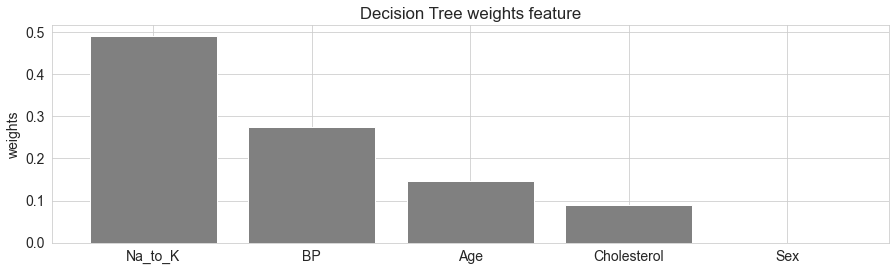

In [34]:
# Веса "вклада" признаков
weights_TREE = pd.Series(data=best_TREE_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(15, 4))
plt.bar(x=weights_TREE.index, height=weights_TREE.values, color='grey')
plt.ylabel('weights')
plt.title('Decision Tree weights feature')
plt.show()

**Случайный лес**

Лучшие параметры: {'max_depth': 6, 'min_samples_leaf': 2, 'n_estimators': 40}


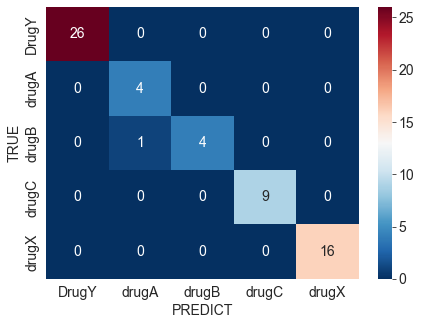

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       0.80      1.00      0.89         4
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00        16

    accuracy                           0.98        60
   macro avg       0.96      0.96      0.96        60
weighted avg       0.99      0.98      0.98        60

Wall time: 18.3 s


In [35]:
%%time
FOREST_model = RandomForestClassifier(random_state=42)
FOREST_params = {'n_estimators': np.arange(10, 50, 10),
                'max_depth': np.arange (2, 10, 2),
                'min_samples_leaf': np.arange(2, 10, 2)}

best_FOREST_model, FOREST_y = modeling(FOREST_model, FOREST_params, X_train, y_train, X_test)
metrics(y_test, FOREST_y)
scores['Random Forest'] = f1_score(y_test, FOREST_y, average='weighted')

**K Neighbors**

Лучшие параметры: {'n_neighbors': 3}


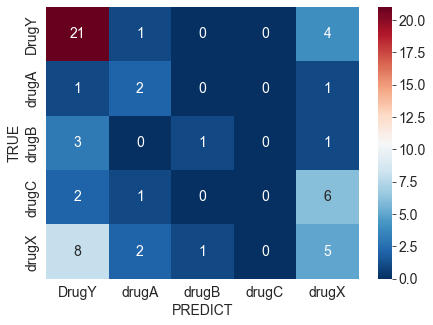

              precision    recall  f1-score   support

           0       0.60      0.81      0.69        26
           1       0.33      0.50      0.40         4
           2       0.50      0.20      0.29         5
           3       0.00      0.00      0.00         9
           4       0.29      0.31      0.30        16

    accuracy                           0.48        60
   macro avg       0.35      0.36      0.34        60
weighted avg       0.40      0.48      0.43        60

Wall time: 1.55 s


In [36]:
%%time
KNN_model = KNeighborsClassifier()
KNN_params = {'n_neighbors': np.arange(3, 50, 2)}

best_KNN_model, KNN_y = modeling(KNN_model, KNN_params, X_train, y_train, X_test)
metrics(y_test, KNN_y)
scores['K Neighbors'] = f1_score(y_test, KNN_y, average='weighted')

**Наивный Байесовский Классификатор**

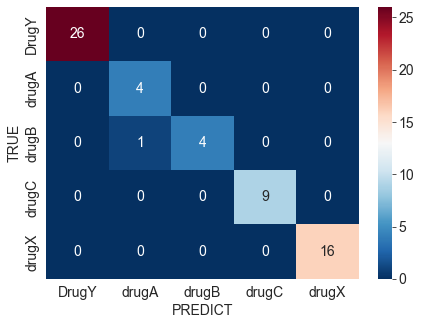

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       0.80      1.00      0.89         4
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00        16

    accuracy                           0.98        60
   macro avg       0.96      0.96      0.96        60
weighted avg       0.99      0.98      0.98        60

Wall time: 396 ms


In [37]:
%%time
BAYES_model = GaussianNB()
BAYES_model.fit(X_train, y_train)
BAYES_y = BAYES_model.predict(X_test)
metrics(y_test, BAYES_y)
scores['Gaussian NB'] = f1_score(y_test, BAYES_y, average='weighted')

**SVM**

Лучшие параметры: {'gamma': 'scale', 'kernel': 'linear'}


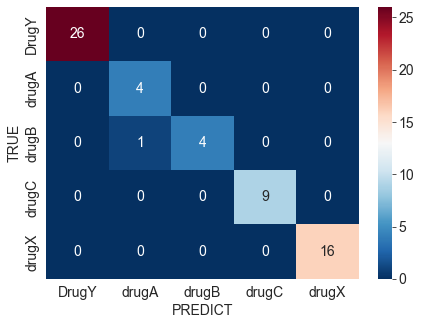

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       0.80      1.00      0.89         4
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00        16

    accuracy                           0.98        60
   macro avg       0.96      0.96      0.96        60
weighted avg       0.99      0.98      0.98        60

Wall time: 829 ms


In [38]:
%%time
SVC_model = SVC(random_state=42)
SVC_params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
             'gamma': ['scale', 'auto']}

best_SVC_model, SVC_y = modeling(SVC_model, SVC_params, X_train, y_train, X_test)
metrics(y_test, SVC_y)
scores['SVM'] = f1_score(y_test, SVC_y, average='weighted')

**Выводы**

In [45]:
print('F1-score рассмотренных моделей:')
scores.sort_values(ascending=False)

F1-score рассмотренных моделей:


Decision Tree          0.983333
Random Forest          0.983333
Gaussian NB            0.983333
SVM                    0.983333
Logistic Regression    0.866228
K Neighbors            0.429645
dtype: float64

- В целом большинство моделей (Decision Tree, Random Forest, Gaussian NB, SVM) очень хорошо справились с поставленной задачей классификации.
- Decision Tree, Random Forest, Gaussian NB, SVM имеют одинаковые матрицы ошибок. Данные модели допускали ошибки в определении классов 'drugA', 'drugB'. Точность данных моделей составила 98%. Из 60 наблюдений было неправильно распределено одно значений.
- Хуже всего с поставленной задачей справился алгоритм K Neighbors, точность которого составляет 43% 
- Наилучшее быстродейтсвие показала модель GaussianNB, кроме того данная модель не нуждалась в подборе оптимальных параметров.